In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/'
stispath = '{}stis/'.format(path)
cospath = '{}cos/'.format(path)

In [6]:
x1ds = np.hstack((glob.glob('{}*0_x1d.fits'.format(stispath)), glob.glob('{}*sx1.fits'.format(stispath))))#, glob.glob('{}*x1dsum.fits'.format(path))))
x1ds


array(['/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03030_sx1.fits'],
      dtype='<U70')

/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03010_x1d.fits
G140M
[173.27858]


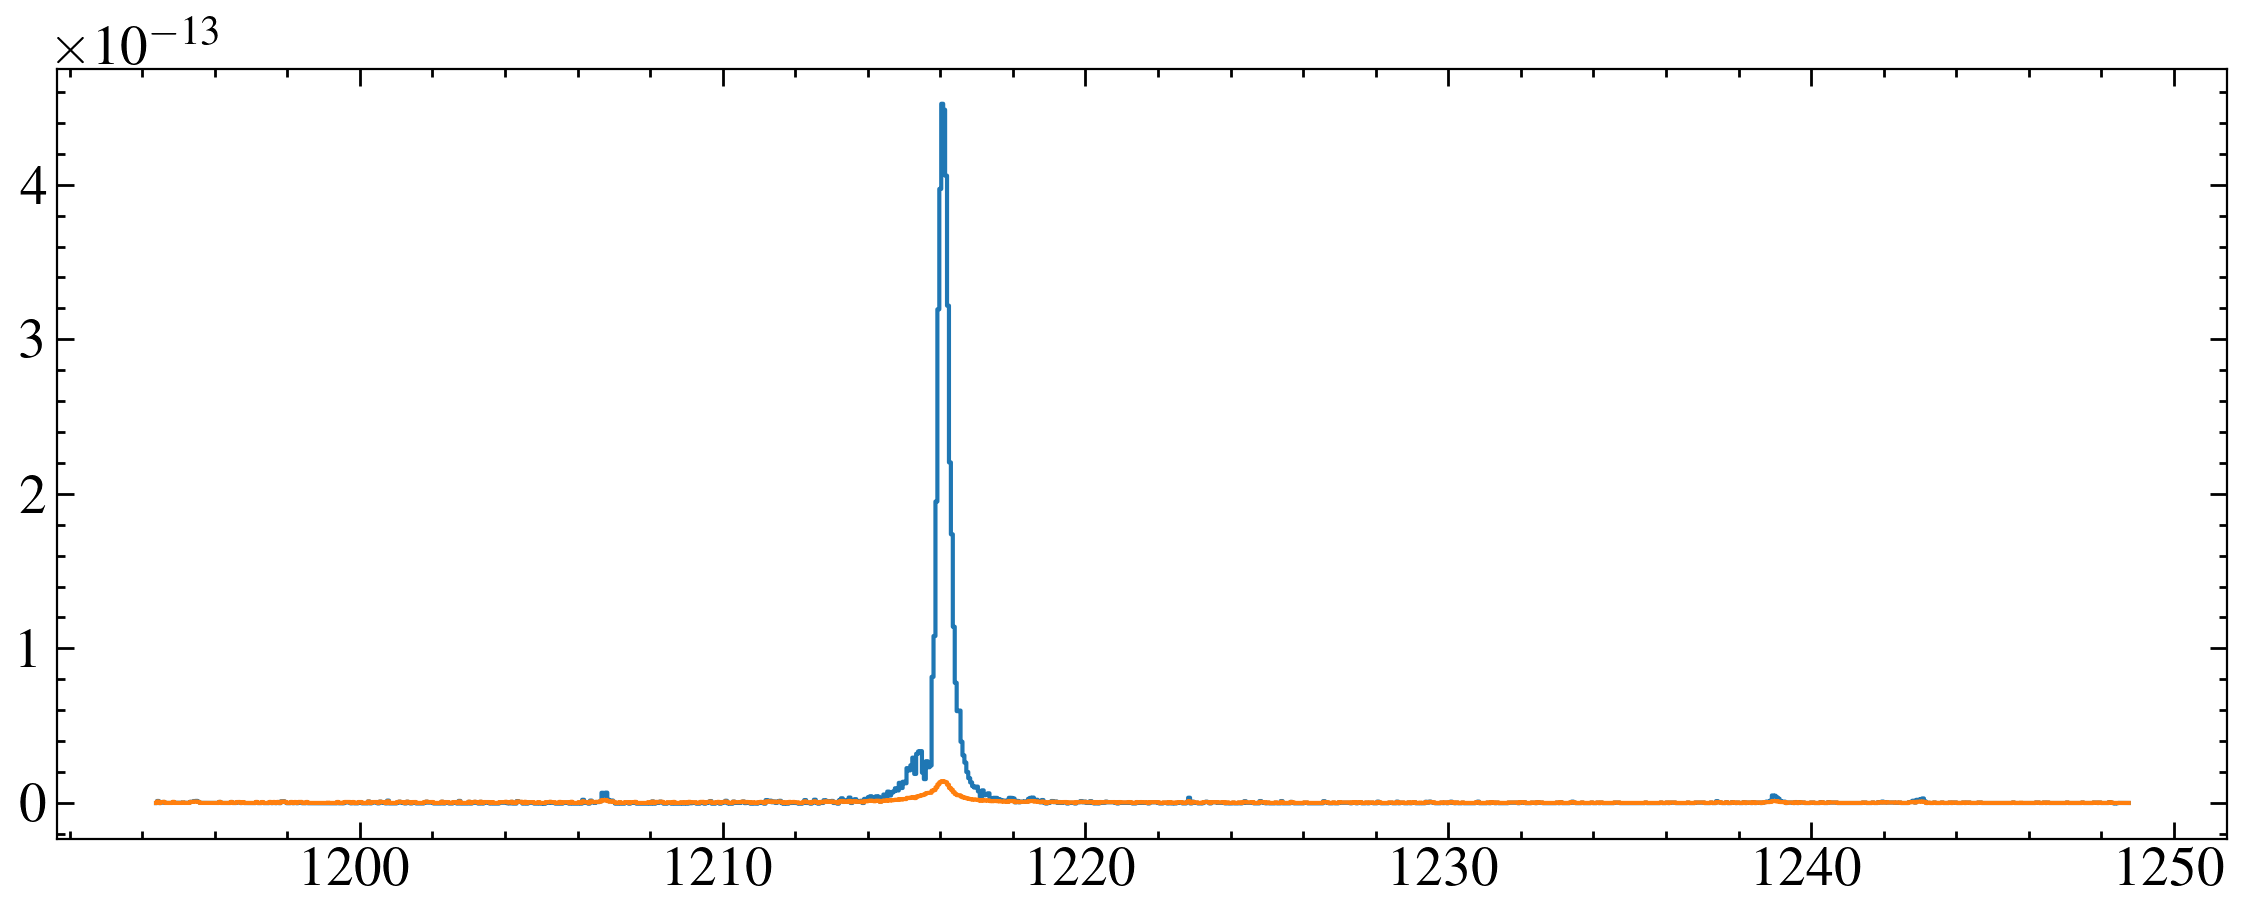

/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03020_x1d.fits
G230L
[528.51666]


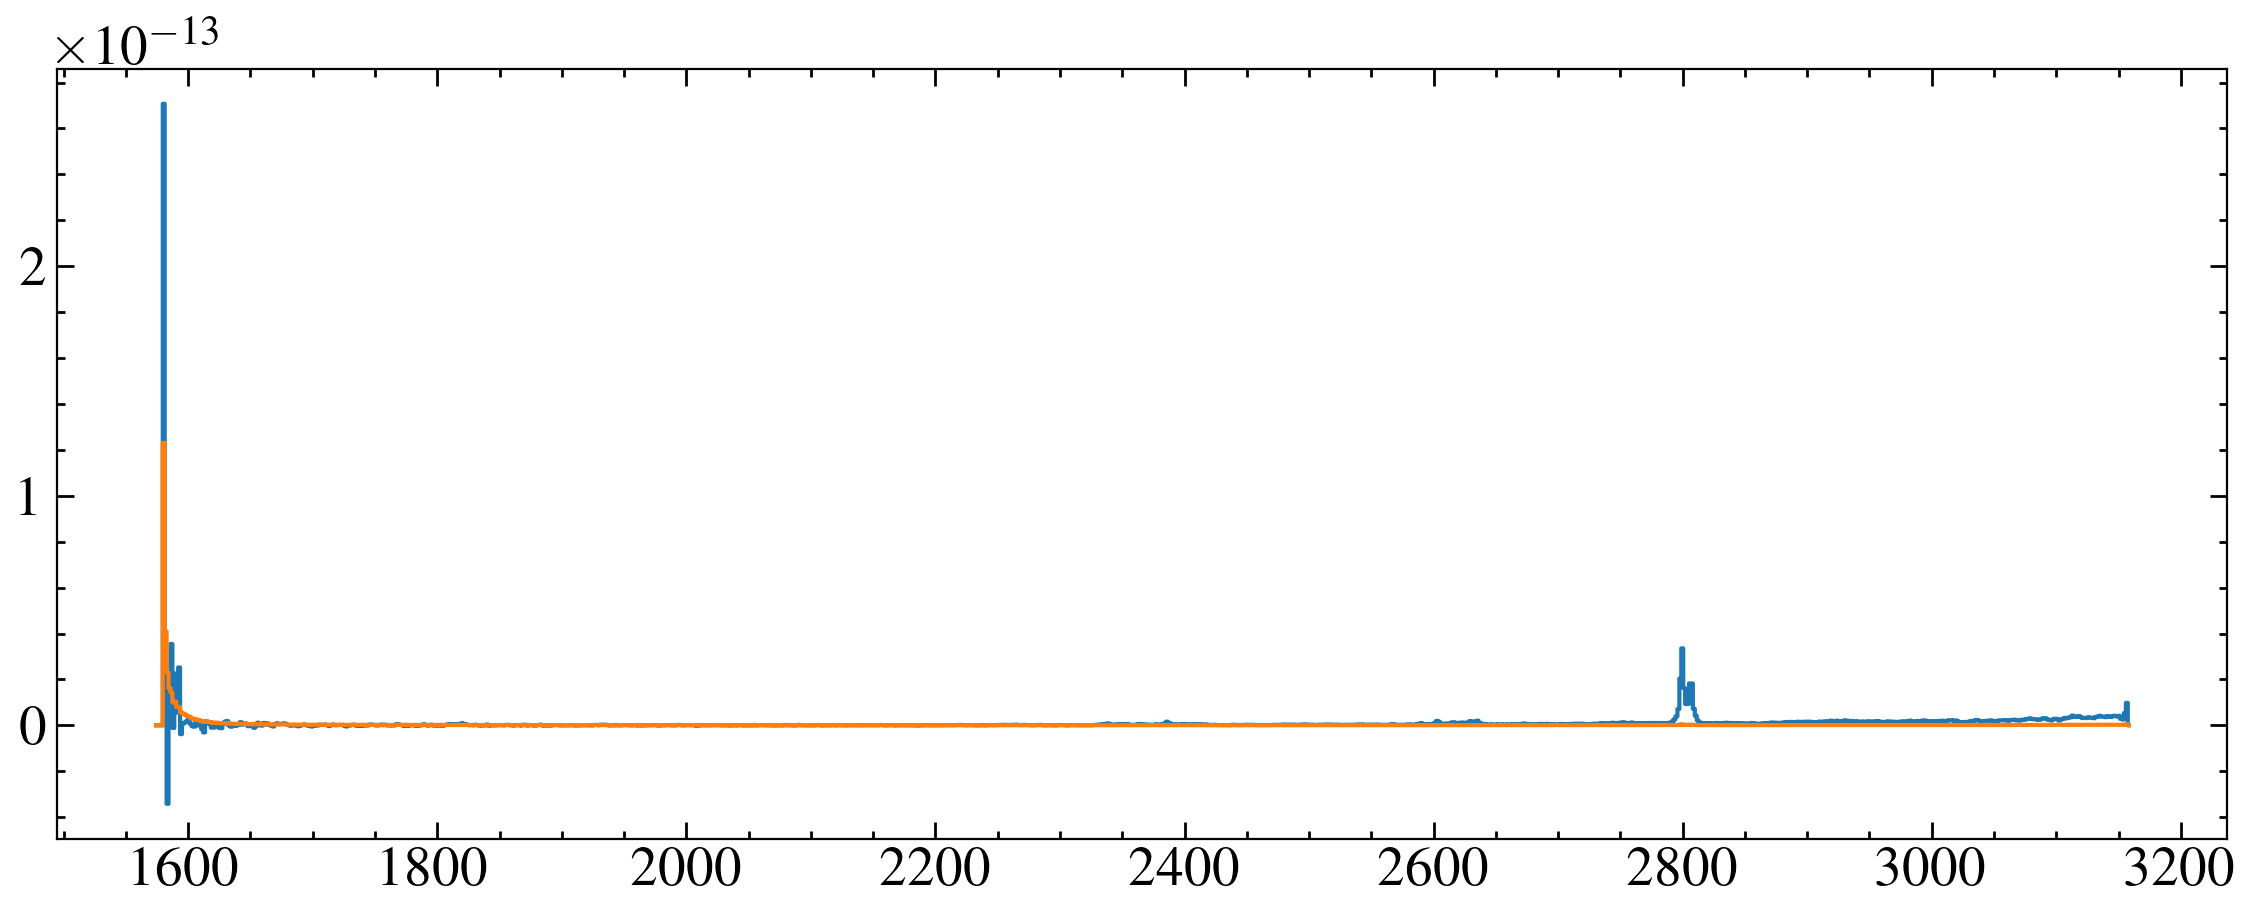

/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03030_sx1.fits
G430L
[894.6452]


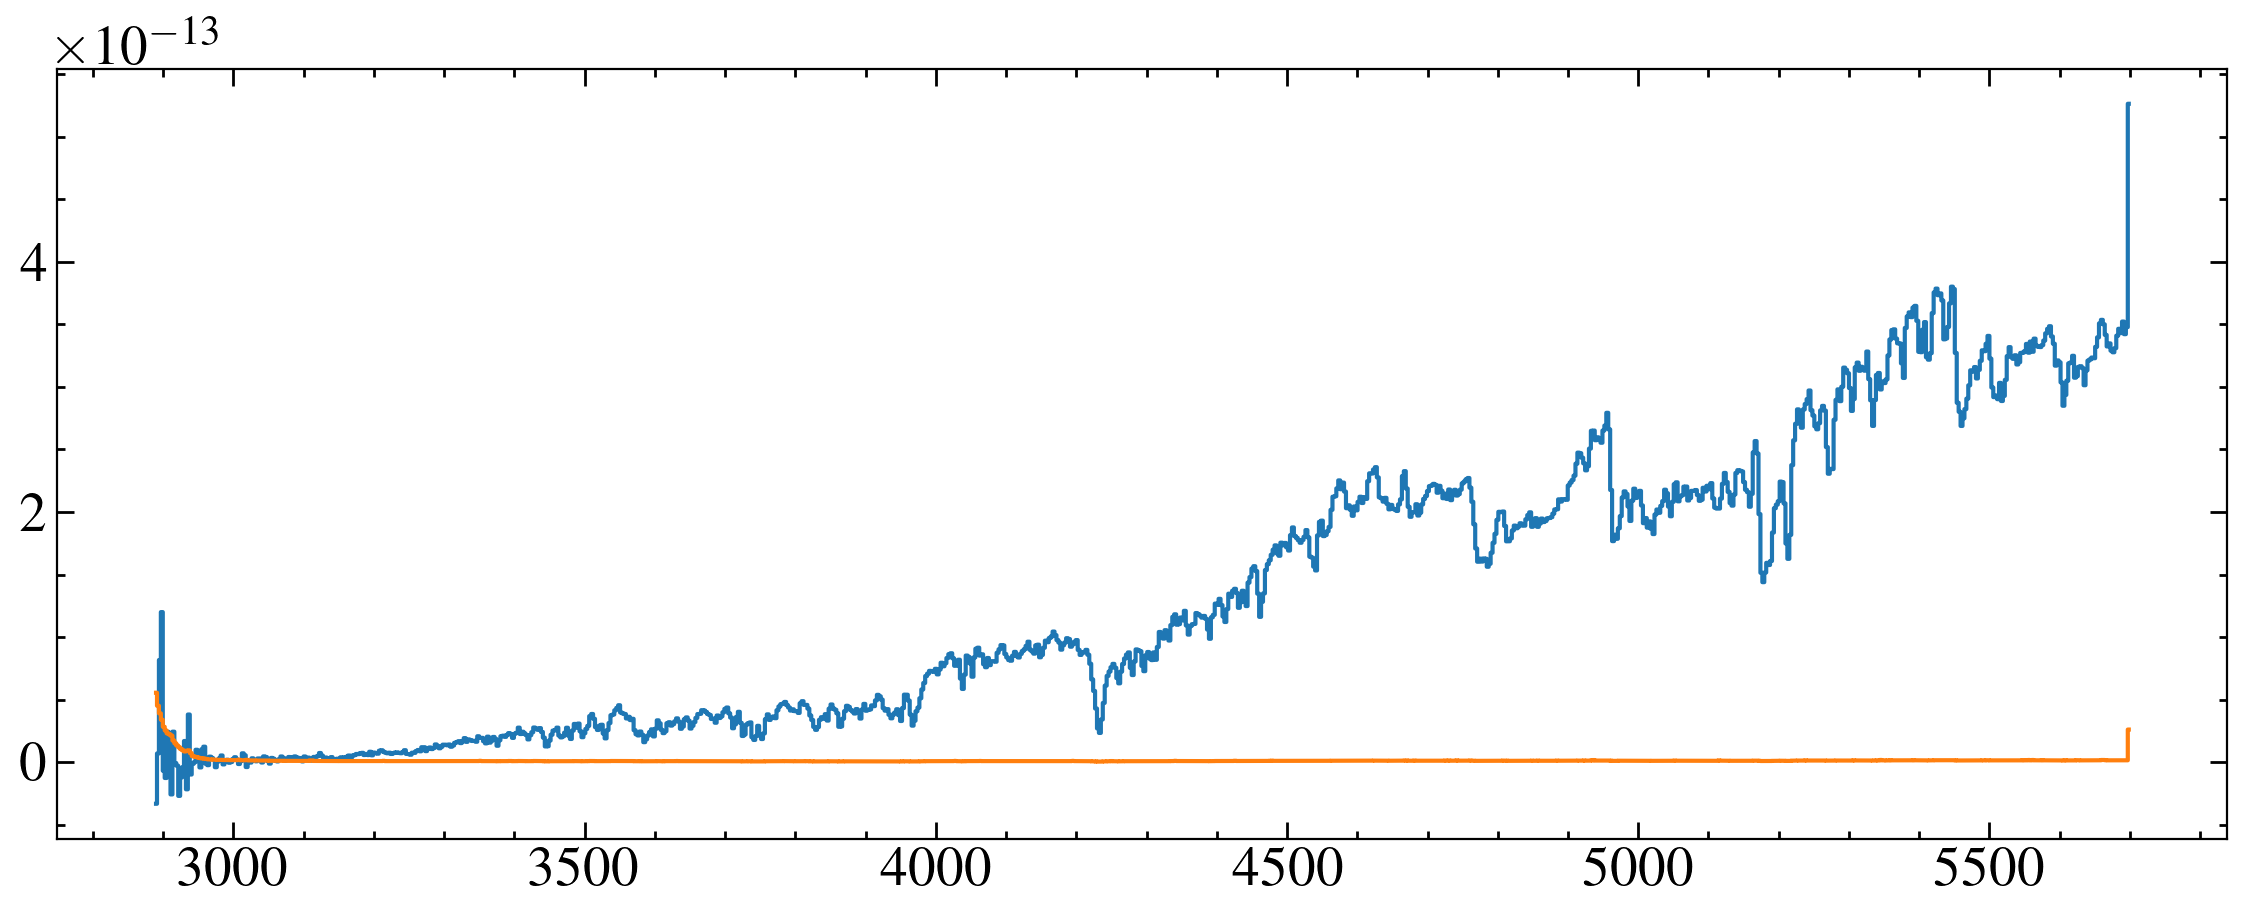

In [7]:
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')
    plt.show()

    

/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03010_x1d.fits
G140M
173.27858
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03020_x1d.fits
G230L
528.51666
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/stis/oeoo03030_sx1.fits
G430L
894.6452


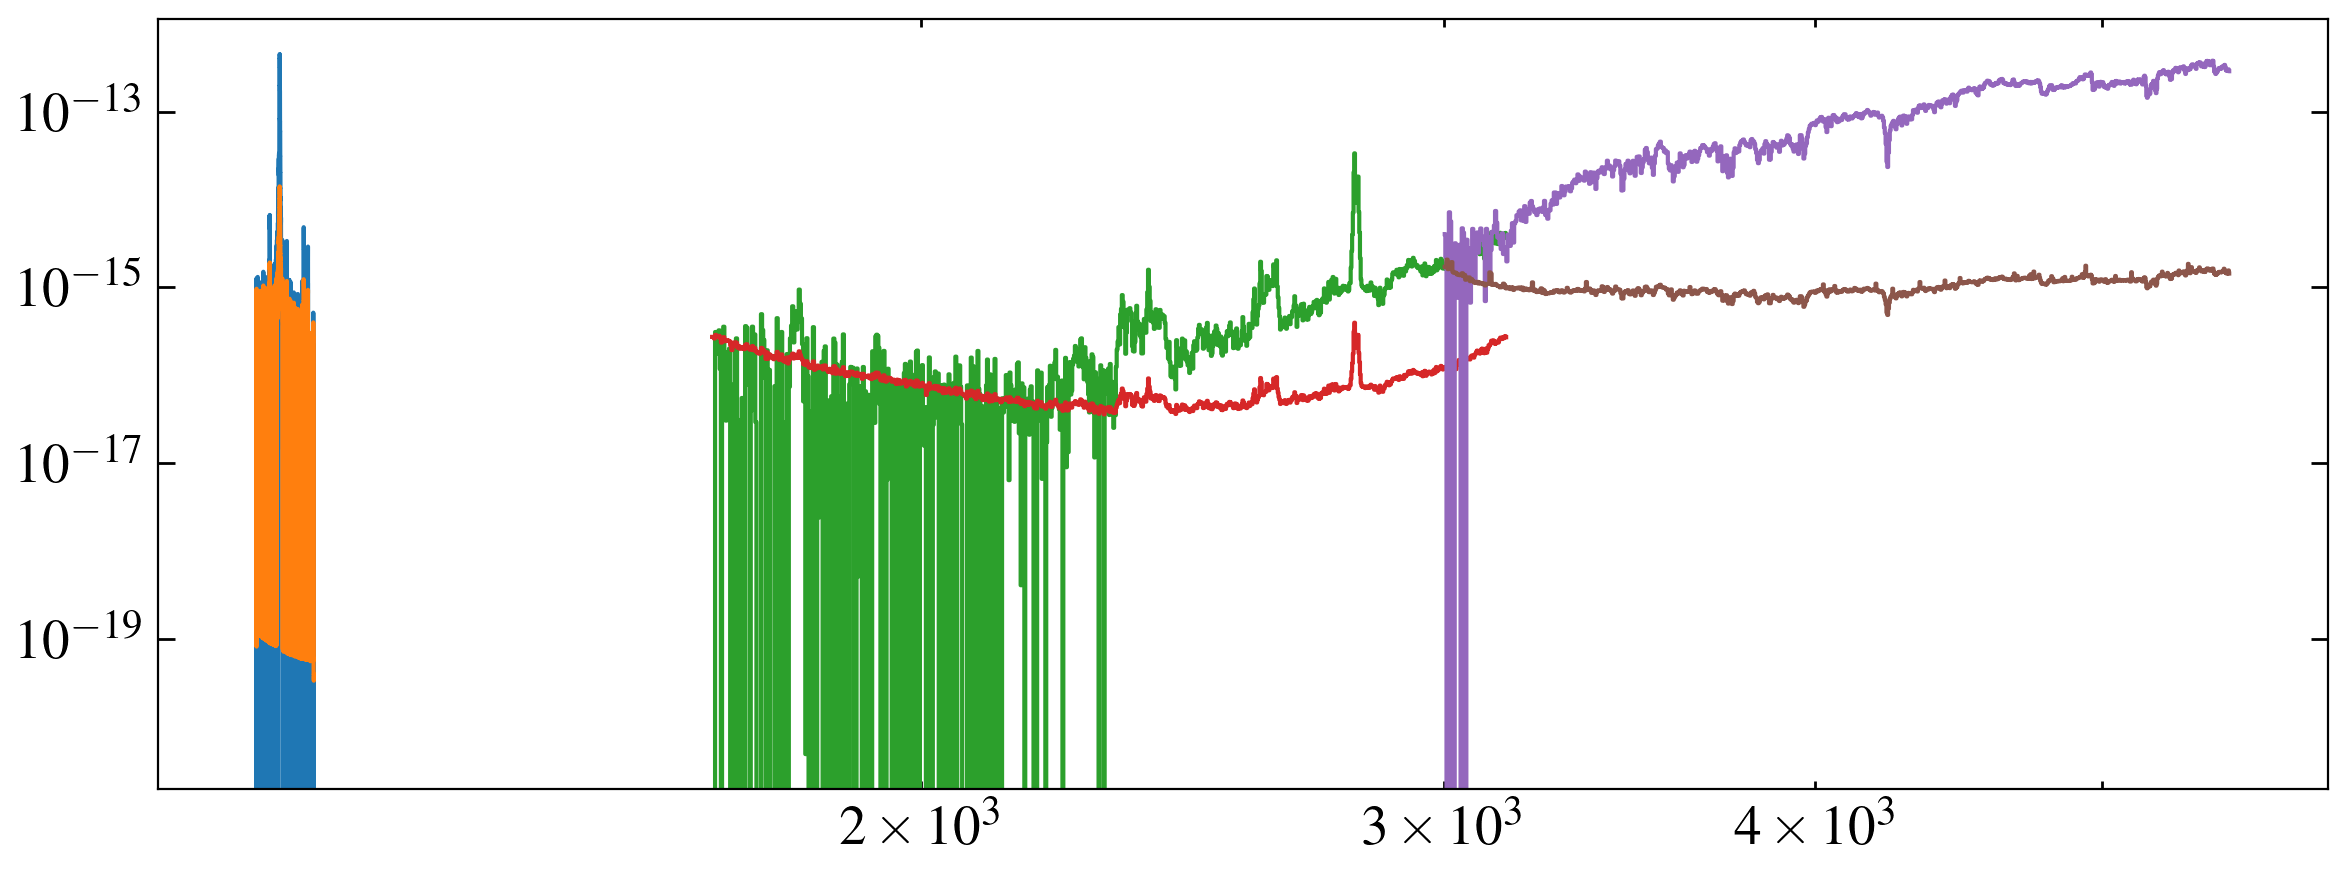

In [11]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating in ['G140M', 'G140L']:
        mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    if grating =='G230L':
        mask = (w > 1700) & (w < 3150)
    if grating =='G430L':
        mask = (w > 3000) & (w < 5520)
    
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
#     plt.show()
    
plt.yscale('log')
plt.xscale('log')

STIS all looks good. Rest of the data is COS - need to update prepare_cos for Meats

In [14]:
import importlib
import prepare_stis
importlib.reload(prepare_stis)

<module 'prepare_stis' from '/home/david/work/meats/SEDs/prepare_stis.py'>

/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/astropy/stats/funcs.py:702: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]


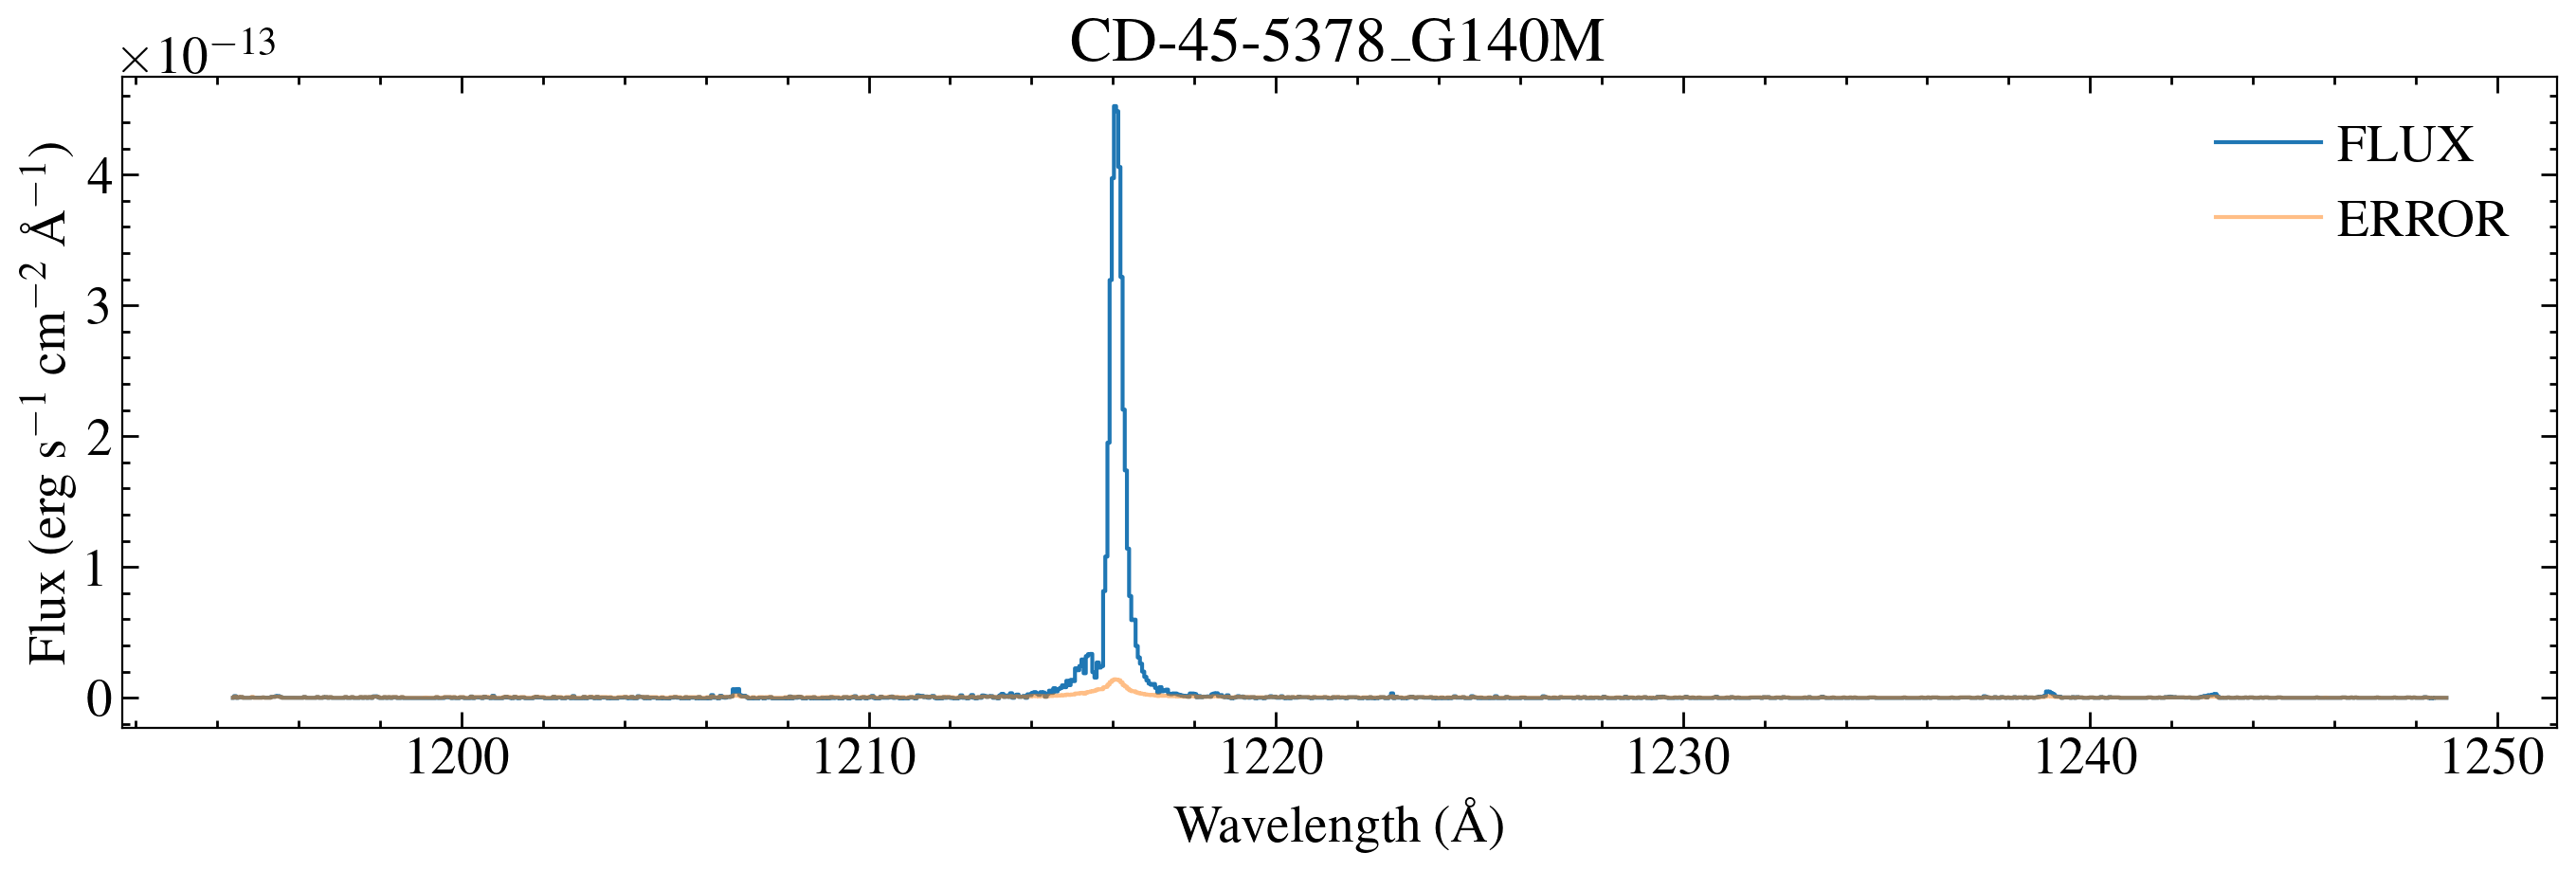

Spectrum saved as hlsp_muscles_hst_stis_cd-45-5378_g140m_v1_component-spec.fits


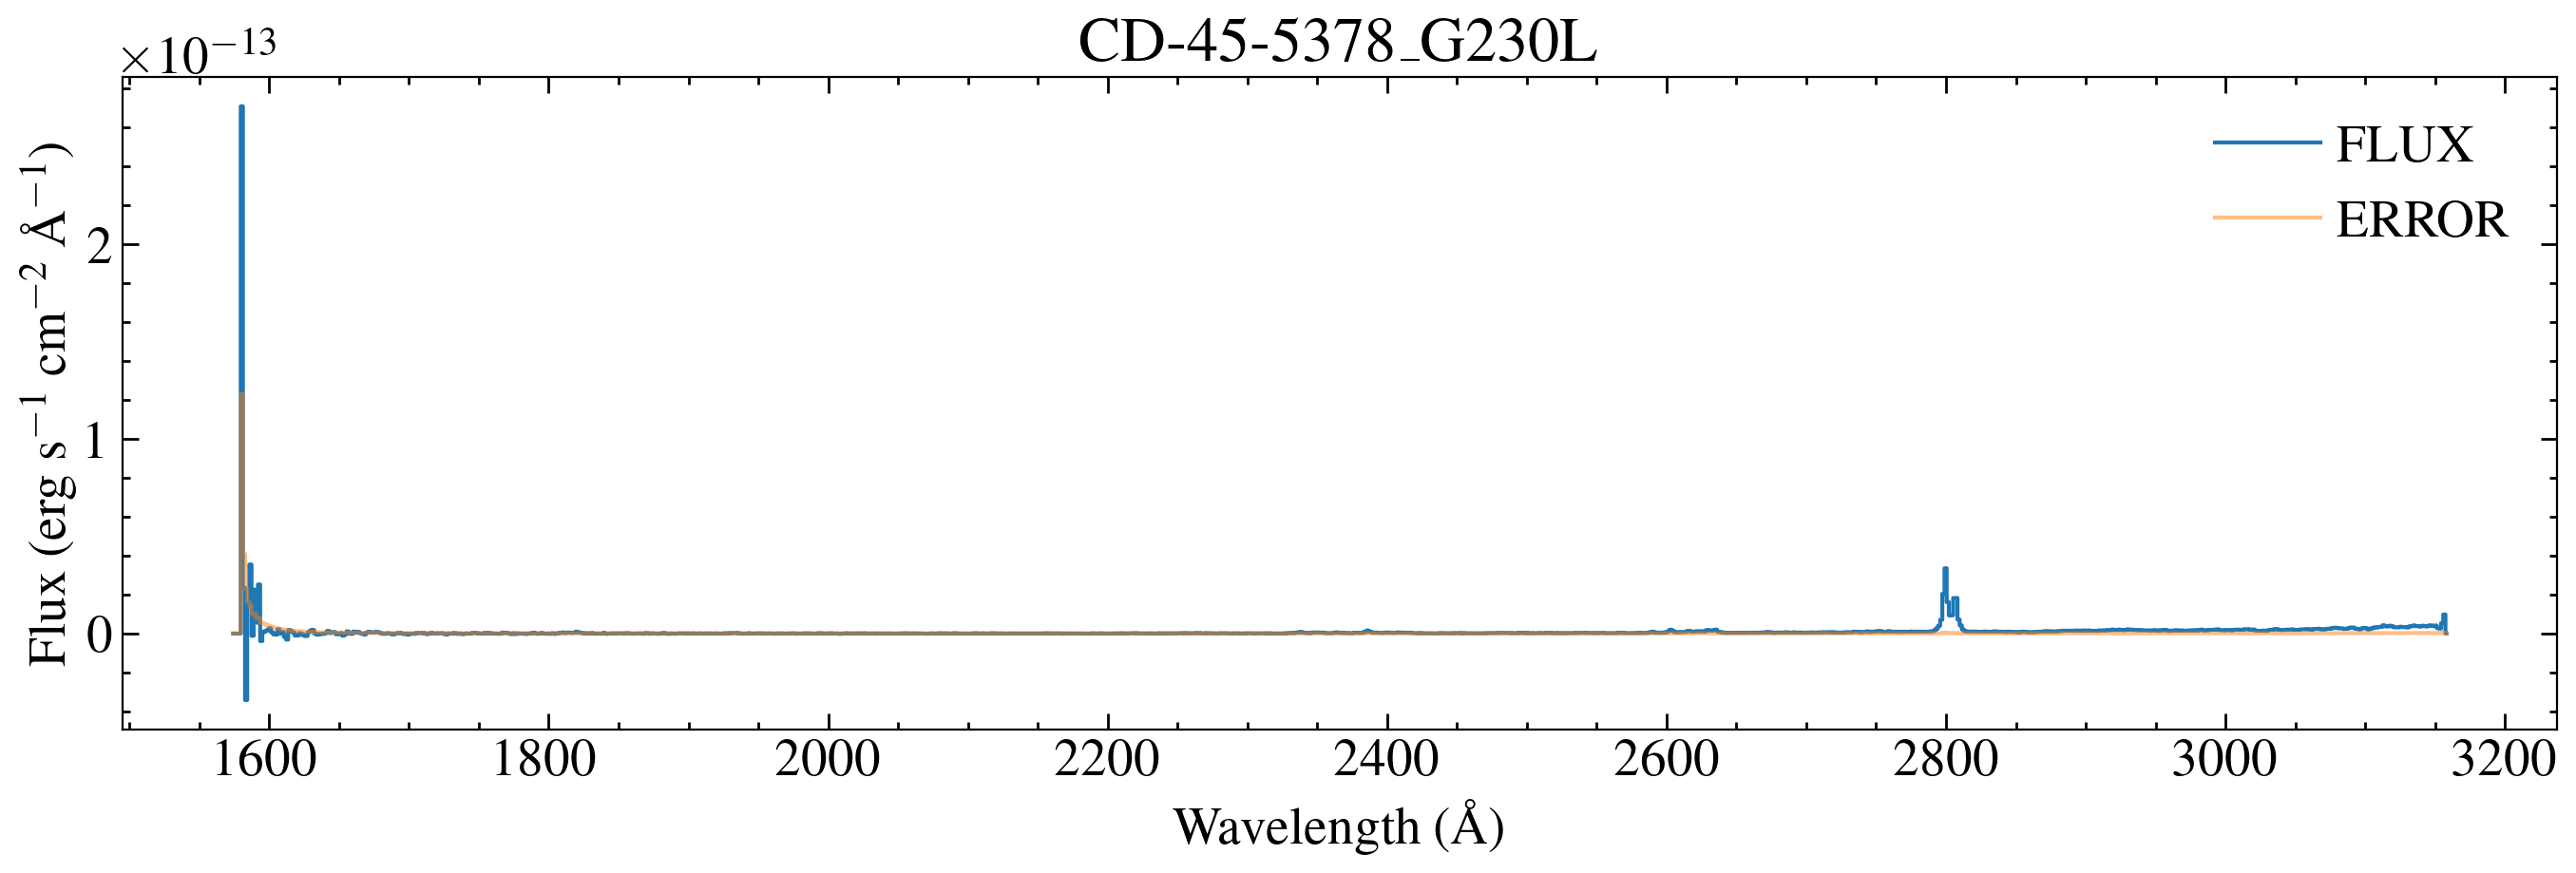

Spectrum saved as hlsp_muscles_hst_stis_cd-45-5378_g230l_v1_component-spec.fits


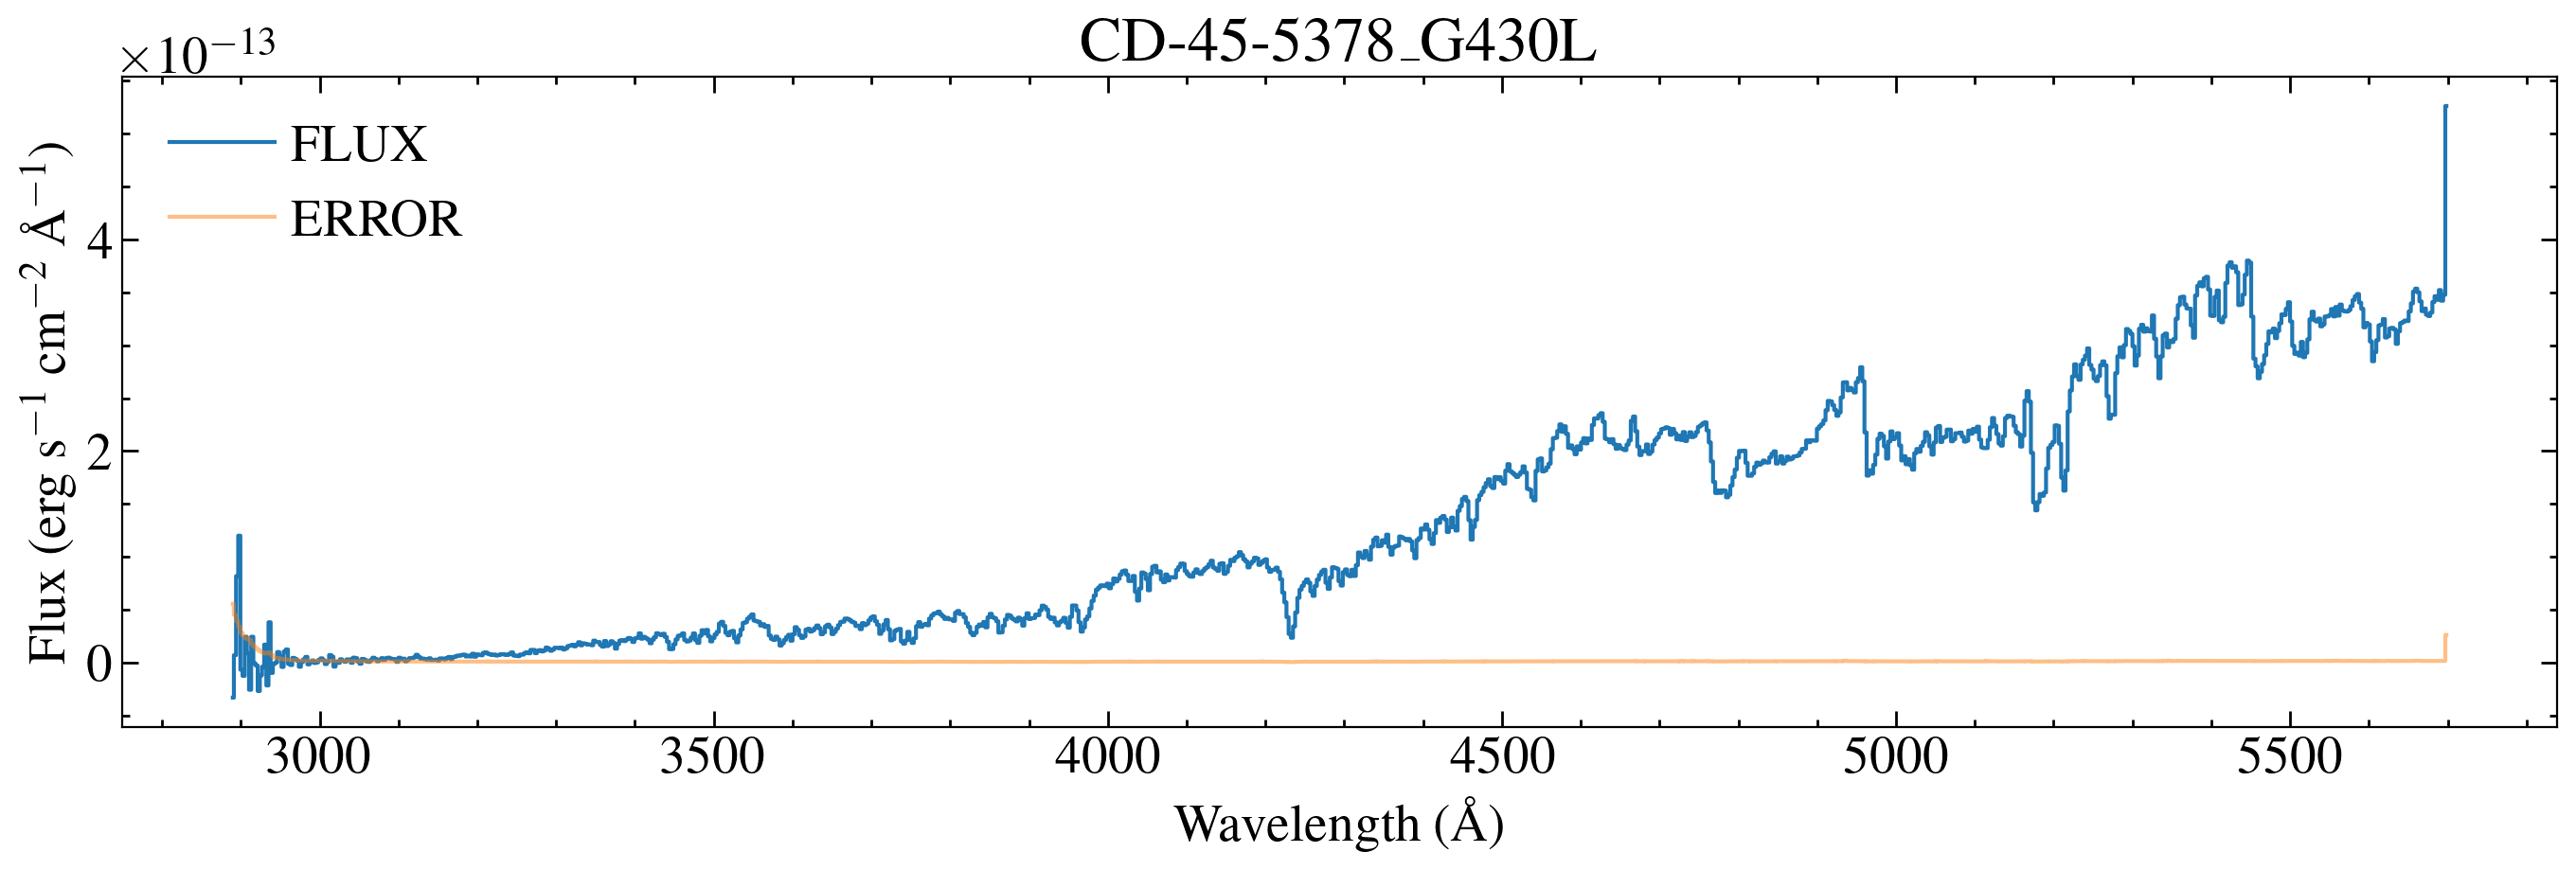

Spectrum saved as hlsp_muscles_hst_stis_cd-45-5378_g430l_v1_component-spec.fits


In [15]:
x1dpath = stispath
savepath = 'draft_hlsp/gj_367/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = '')

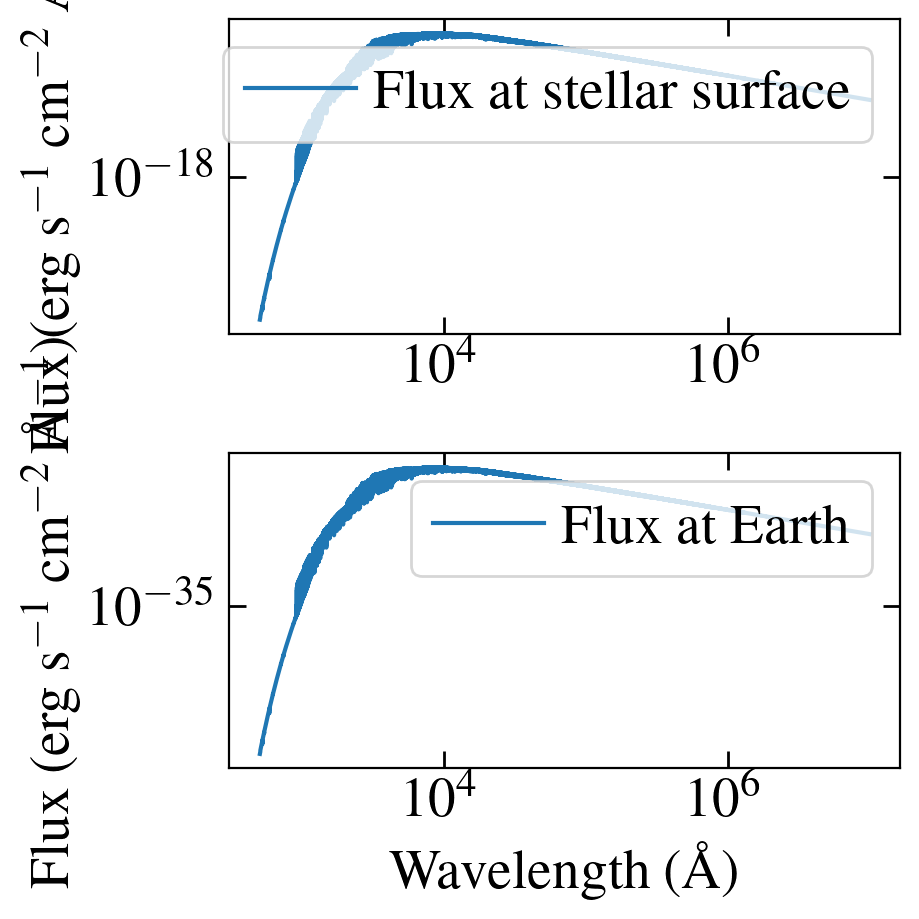

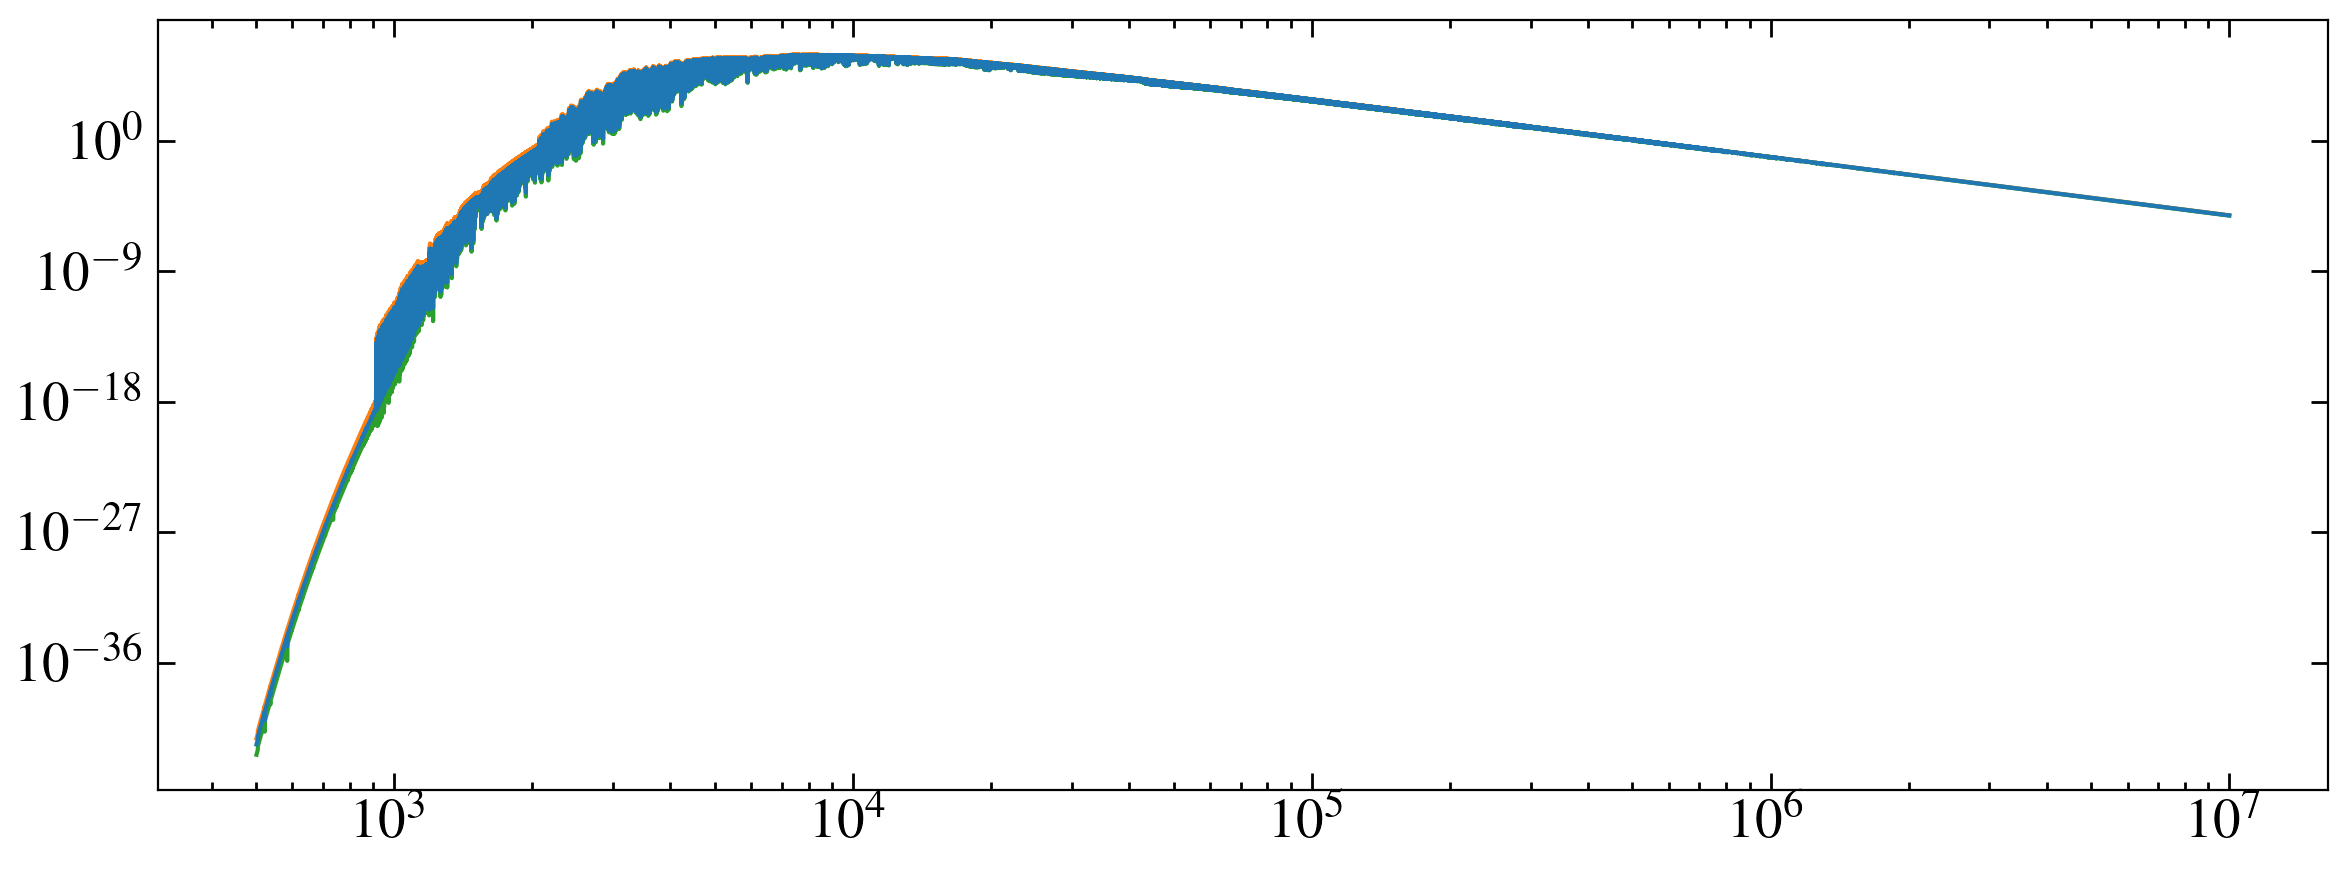

In [16]:
import prepare_phoenix_svo as pp
importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.454
teff = 3522
teff_e = 70

radius = 0.457
distance = 9.42

save_path = 'models/'
star = 'GJ_367'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.777
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [18]:
hlsp_x1ds = glob.glob('draft_hlsp/gj_367/*stis*.fits')
hlsp_x1ds

['draft_hlsp/gj_367/hlsp_muscles_hst_stis_cd-45-5378_g140m_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_hst_stis_cd-45-5378_g430l_v1_component-spec.fits',
 'draft_hlsp/gj_367/hlsp_muscles_hst_stis_cd-45-5378_g230l_v1_component-spec.fits']

draft_hlsp/gj_367/hlsp_muscles_hst_stis_cd-45-5378_g430l_v1_component-spec.fits
draft_hlsp/gj_367/hlsp_muscles_hst_stis_cd-45-5378_g230l_v1_component-spec.fits


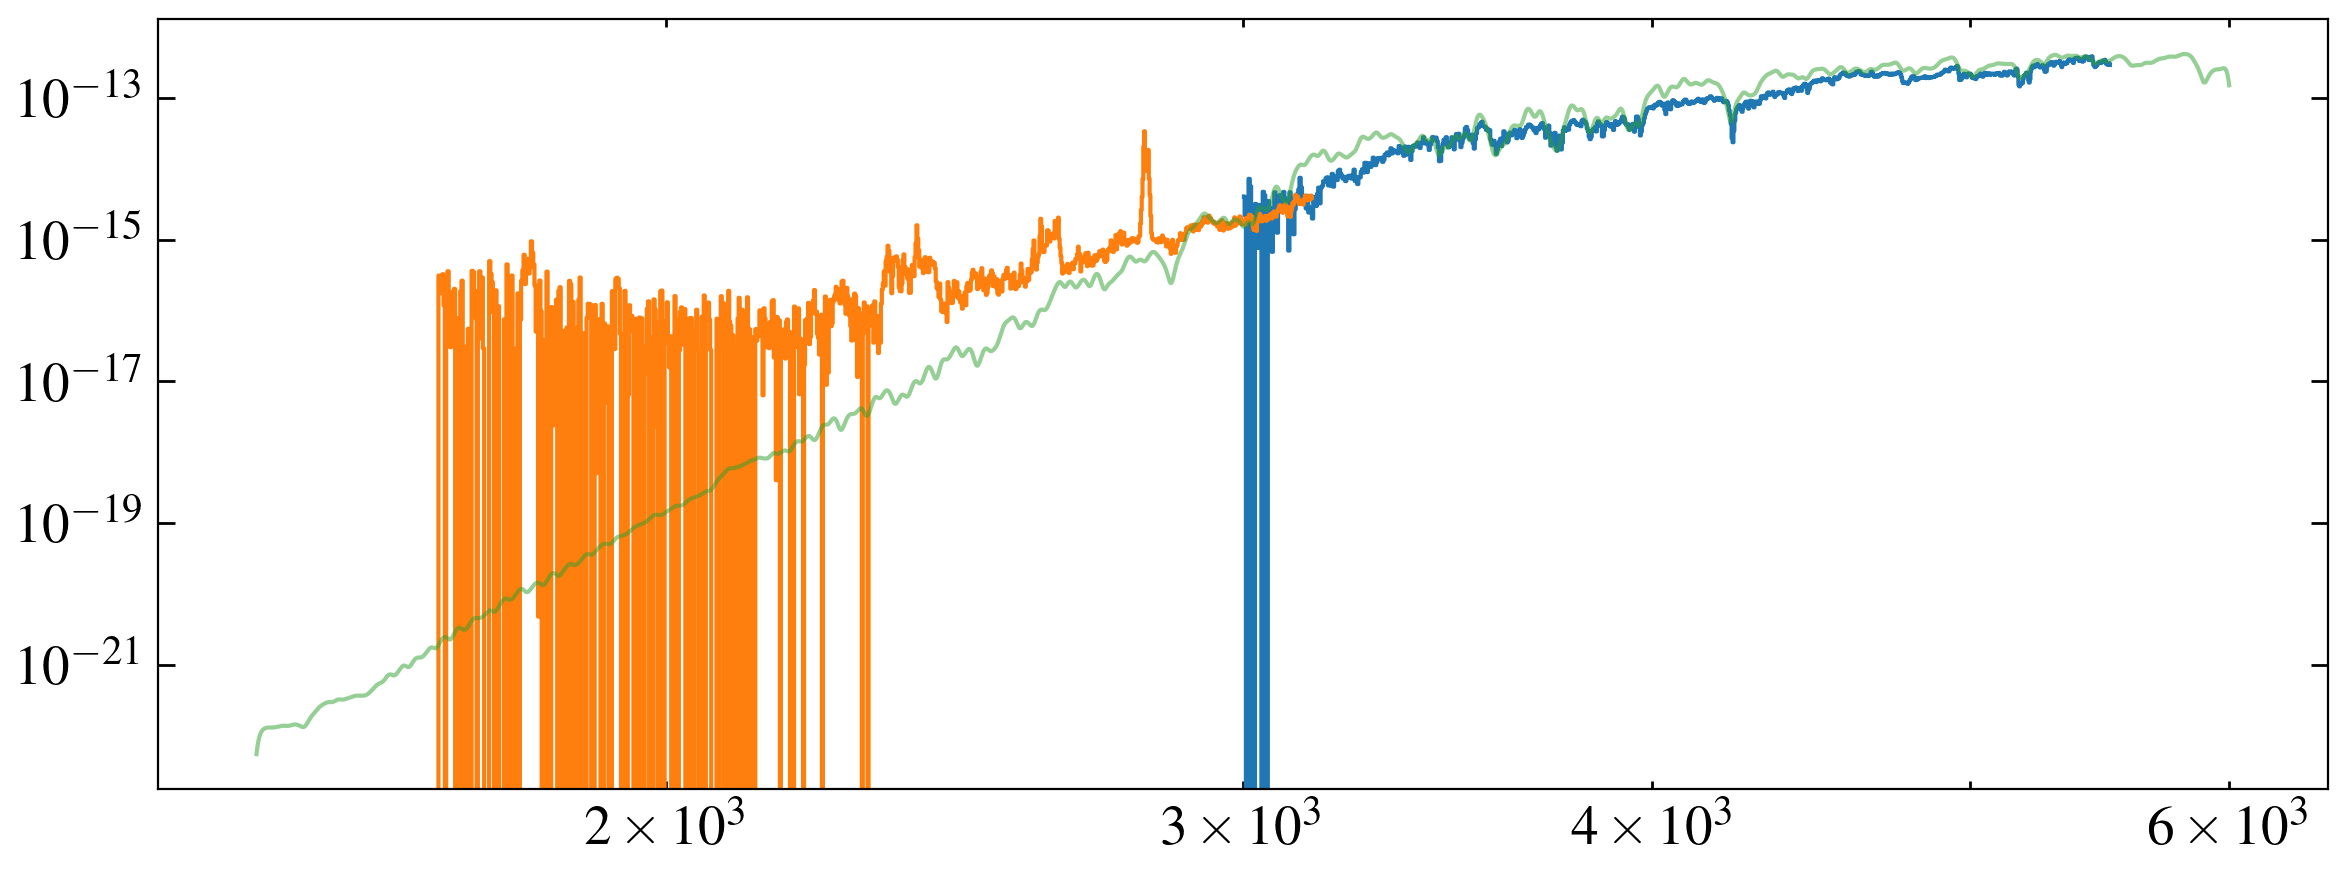

In [26]:
for x in hlsp_x1ds[1:]:
    print(x)
    grating = fits.getheader(x, 0)['GRATING'] 
    data = fits.getdata(x, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     if grating in ['G140M', 'G140L']:
#         mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    if grating =='G230L':
        mask = (w > 1700) & (w < 3150)
    if grating =='G430L':
        mask = (w > 3000) & (w < 5520)
    
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
#     plt.step(w, e, where='mid')
#     plt.show()
   
pmask = (pw > 1500) & (pw < 6000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi,500)
plt.plot(pwi, pfi, alpha=0.5)
    
plt.yscale('log')
plt.xscale('log')

Can live with that given the opacity problem